In [44]:
#!/usr/bin/env python
%matplotlib inline  

#makes AMP module reload
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
from scipy.stats import pearsonr,spearmanr

#pull in the classes to do the sims!
import AMPmodule

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ppt: 1 , exposed: 50 , transmission ratio (conc/IC50): 1e-10
clearance: 57.809999999998446


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


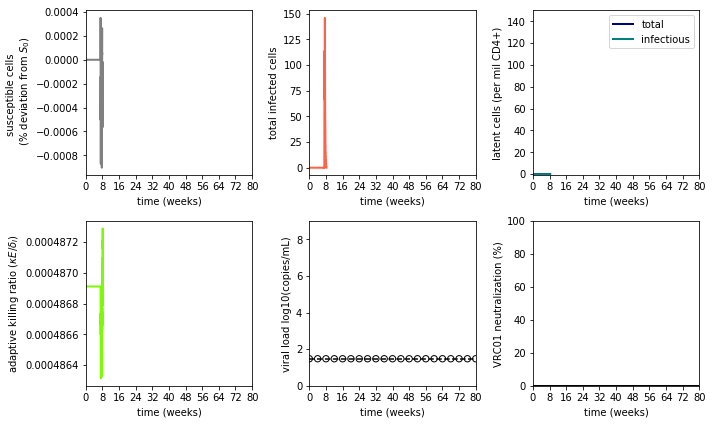

In [57]:
#simple tests for single participant without VRC01, infected on day 50

VD=np.array(pd.read_csv('data/viral_dynamics.csv',usecols=range(1,8)))

vdset=4 #pick the viral dynamics set

p1=AMPmodule.participant(name=1, et=50, tF=560, stop2=False, 
                         A0=1, vdp=VD[vdset,:], pkp=[1e-5,0,0,0], pdp=[1e5,1], v_flg=True)

t,sol=p1.vd_sim()
tAb = np.linspace(0,560,1e3) #time for antibody dose

AMPmodule.simplot(t,sol,tAb,p1,'sto_model-natural')


ppt: 1 , exposed: 50 , transmission ratio (conc/IC50): 3.7517561350643174
clearance: 55.66999999999887


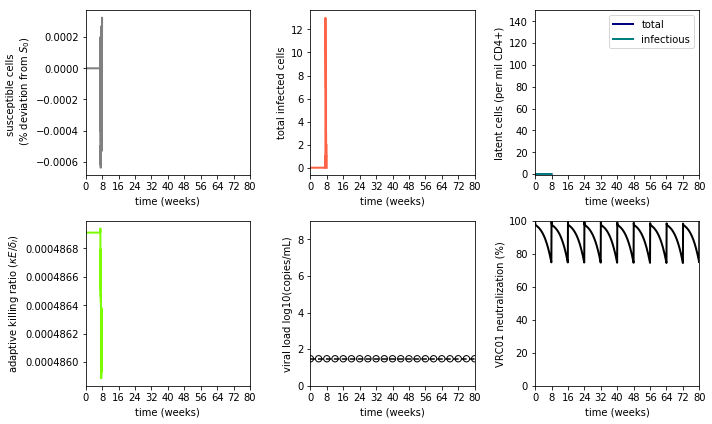

In [54]:
#simple tests for single participant with VRC01

PK=np.array(pd.read_csv('data/PK10.csv',usecols=range(1,5)))
PD=np.array(pd.read_csv('data/PDall.csv',usecols=range(1,3)))

vdset=4 #pick the viral dynamics set
pkset=2
pdset=93

p2=AMPmodule.participant(name=1, et=50, tF=560, stop2=False, 
                         A0=1, vdp=VD[vdset,:], pkp=PK[pkset,:], pdp=PD[pdset,:], v_flg=True)

t,sol=p2.vd_sim()
simplot(t,sol,tAb,p2,'sto_model-VRC01')



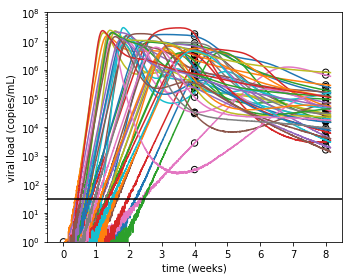

In [58]:
#try all viral dynamics parameter sets without VRC01 in a single dose interval

etf=0 #how to space out for plotting
plt.figure(figsize=(5,4))
for i in range(len(VD)):
    p=AMPmodule.participant(name=1, et=i*etf, tF=8*7+1, stop2=False, A0=1, 
                  vdp=VD[i,:], pkp=[1e-5,0,0,0], pdp=[1e5,1], v_flg=False)

    t,sol=p.vd_sim()
    plt.semilogy(t/7,sol[:,6]/p.vol*1e3)
    plt.scatter(p.obs_times/7,p.obs+0.7**i,facecolors='none',edgecolors='k',s=40)

plt.xlabel('time (weeks)')
plt.ylabel('viral load (copies/mL)')
plt.ylim([1,1e8])
plt.yticks(np.logspace(0,8,9))
plt.axhline(30,color='k')
plt.tight_layout()
plt.xlim([-0.5,8.5])

plt.tight_layout()
plt.savefig('figures/sto_model-natural_all.pdf',dpi=600)


name: 0 conc ratio: 1e-10 first pos time: 0 first pos VL: 0
name: 1 conc ratio: 1e-10 first pos time: 504.00291051501847 first pos VL: 10082.534860000002
name: 2 conc ratio: 1e-10 first pos time: 112.00832394106743 first pos VL: 9043113.96727
name: 3 conc ratio: 1e-10 first pos time: 0 first pos VL: 0
name: 4 conc ratio: 1e-10 first pos time: 0 first pos VL: 0
name: 5 conc ratio: 1e-10 first pos time: 0 first pos VL: 0
name: 6 conc ratio: 1e-10 first pos time: 280.0027899235344 first pos VL: 245698.24091000002
name: 7 conc ratio: 1e-10 first pos time: 364.00301160809965 first pos VL: 162705.22027000002
name: 8 conc ratio: 1e-10 first pos time: 112.00429219066275 first pos VL: 10376.093499999999
name: 9 conc ratio: 1e-10 first pos time: 532.0060076823955 first pos VL: 4684821.46992
name: 10 conc ratio: 1e-10 first pos time: 84.00703914607128 first pos VL: 177177.03686999998
name: 11 conc ratio: 1e-10 first pos time: 392.0077990466552 first pos VL: 49.285450000000004
name: 12 conc ratio:

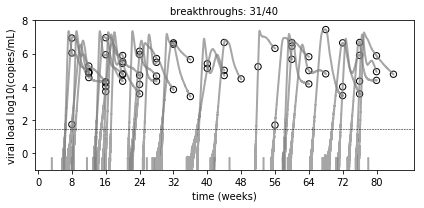

In [87]:
#now simple test of contrl trial in 

#%time 
tr=AMPmodule.trial(name='test', nps=40, tF=560, dose=0, clade='B', 
                   rfrac=0, A0=1, iv_phi=1, maxIC50=50, 
                   v_flg=True, keep_flg=2)

#plot trial outcome
plt.figure(figsize=(6,3))
for ip in range(tr.nps):
    plt.scatter(tr.obz[0][ip][tr.obz[1][ip]>30]/7,
                np.log10(tr.obz[1][ip][tr.obz[1][ip]>30]),
                facecolors='none',edgecolors='k',s=40)#,c=plt.cm.jet(ip))#1.4**ip),alpha=0.7)
    plt.plot(tr.sim[0][ip][tr.sim[1][ip]>-3]/7,
             tr.sim[1][ip][tr.sim[1][ip]>-3],
             lw=2,color='gray',alpha=0.7)    

plt.axhline(np.log10(30),color='k',ls='--',lw=0.5)
plt.ylim([-1,8])
plt.ylabel('viral load log10(copies/mL)')
plt.xlabel('time (weeks)')
plt.xticks(range(0,82,8))#,fontsize=8)
plt.title('breakthroughs: '+str(sum(tr.brks>0))+'/'+str(tr.nps),fontsize=10)
#plt.legend(['breakthroughs: '+str(sum(tr.brks>0))+'/'+str(tr.nps)],fontsize=10)
plt.tight_layout()
plt.savefig('figures/trial_ctltest.pdf',dpi=600)

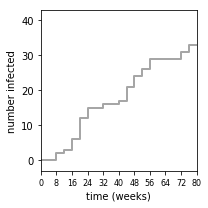

In [79]:
#calculate incidence, of those with brkthrough, how many happened before each interval
inc=np.zeros(len(tr.obz[0][0]))
for i in range(len(tr.obz[0][0])):
    inc[i]=np.sum(tr.brks[tr.brks>0]<tr.obz[0][0][i]) 
    
plt.figure(figsize=(3,3))
plt.step(tr.obz[0][0]/7,inc,lw=2,color='gray',alpha=0.7,where='post')
plt.ylabel('number infected')
plt.xlim([0,80])
plt.ylim([-3,43])
plt.xticks(range(0,82,8),fontsize=8)
plt.xlabel('time (weeks)')
plt.tight_layout()
#plt.savefig('figures/trial_ctltest-inc.pdf',dpi=600)

name: 0 conc ratio: 8.519084756120154 first pos time: 0 first pos VL: 0
name: 1 conc ratio: 25.34974532767519 first pos time: 0 first pos VL: 0
name: 2 conc ratio: 44.46809987651704 first pos time: 0 first pos VL: 0
name: 3 conc ratio: 28.85900801268592 first pos time: 0 first pos VL: 0
name: 4 conc ratio: 120.07259215038053 first pos time: 0 first pos VL: 0
name: 5 conc ratio: 4.946833190959929 first pos time: 0 first pos VL: 0
name: 6 conc ratio: 107.7997589343885 first pos time: 0 first pos VL: 0
name: 7 conc ratio: 231.91699654676367 first pos time: 0 first pos VL: 0
name: 8 conc ratio: 100.44695229037428 first pos time: 0 first pos VL: 0
name: 9 conc ratio: 891.6237775421669 first pos time: 0 first pos VL: 0
name: 10 conc ratio: 708.245676138726 first pos time: 0 first pos VL: 0
name: 11 conc ratio: 1.4193022692099304 first pos time: 0 first pos VL: 0
name: 12 conc ratio: 116.90697871971662 first pos time: 0 first pos VL: 0
name: 13 conc ratio: 295.23949360582037 first pos time: 0

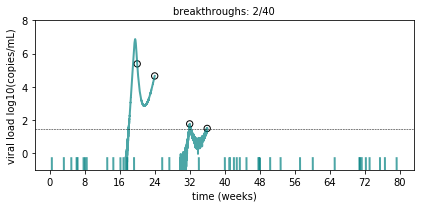

In [86]:
#now simple test of trial including VRC01
%time tr=AMPmodule.trial(name='test', nps=40, tF=560, dose=10, clade='C', rfrac=0, A0=1, iv_phi=1, maxIC50=50, v_flg=True, keep_flg=2)

#plot trial outcome
plt.figure(figsize=(6,3))
for ip in range(tr.nps):
    plt.scatter(tr.obz[0][ip][tr.obz[1][ip]>30]/7,
                np.log10(tr.obz[1][ip][tr.obz[1][ip]>30]),
                facecolors='none',edgecolors='k',s=40)#,c=plt.cm.jet(ip))#1.4**ip),alpha=0.7)
    #plt.scatter(tr.obz[0][ip]/7,np.log10(tr.obz[1][ip]+4e-4*1.1**ip),facecolors='none',edgecolors='k',s=40)#,c=plt.cm.jet(ip))#1.4**ip),alpha=0.7)
    plt.plot(tr.sim[0][ip][tr.sim[1][ip]>-3]/7,
             tr.sim[1][ip][tr.sim[1][ip]>-3],
             lw=2,color='teal',alpha=0.7)    

plt.axhline(np.log10(30),color='k',ls='--',lw=0.5)
plt.xticks(range(0,82,8))#,fontsize=8)
plt.ylim([-1,8])
plt.ylabel('viral load log10(copies/mL)')
plt.xlabel('time (weeks)')
plt.title('breakthroughs: '+str(sum(tr.brks>0))+'/'+str(tr.nps),fontsize=10)
plt.tight_layout()
plt.savefig('figures/trial_10test.pdf',dpi=600)

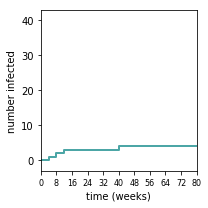

In [82]:
#calculate incidence
inc=np.zeros(len(tr.obz[0][0]))
for i in range(len(tr.obz[0][0])):
    inc[i]=np.sum(tr.brks[tr.brks>0]<tr.obz[0][0][i]) 
    
plt.figure(figsize=(3,3))
plt.step(tr.obz[0][0]/7,inc,lw=2,color='teal',alpha=0.7)
plt.ylabel('number infected')
plt.xlim([0,80])
plt.ylim([-3,43])

plt.xticks(range(0,82,8),fontsize=8)
plt.xlabel('time (weeks)')
plt.tight_layout()
#plt.savefig('figures/trial_10test-inc.pdf',dpi=600)

name: 0 conc ratio: 152.15883569431344 first pos time: 0 first pos VL: 0
name: 1 conc ratio: 153.42171364944355 first pos time: 0 first pos VL: 0
name: 2 conc ratio: 58.44613759664181 first pos time: 0 first pos VL: 0
name: 3 conc ratio: 2095.7727018402566 first pos time: 0 first pos VL: 0
name: 4 conc ratio: 38.322011323874506 first pos time: 0 first pos VL: 0
name: 5 conc ratio: 80.57220593068675 first pos time: 0 first pos VL: 0
name: 6 conc ratio: 75.82106765015506 first pos time: 0 first pos VL: 0
name: 7 conc ratio: 54.433462995225845 first pos time: 0 first pos VL: 0
name: 8 conc ratio: 7.00480457199231 first pos time: 0 first pos VL: 0
name: 9 conc ratio: 347.2879390349034 first pos time: 0 first pos VL: 0
name: 10 conc ratio: 1.9814318529718462 first pos time: 0 first pos VL: 0
name: 11 conc ratio: 6.291352016323385 first pos time: 0 first pos VL: 0
name: 12 conc ratio: 199.04910385288764 first pos time: 0 first pos VL: 0
name: 13 conc ratio: 325.01329708294094 first pos time:

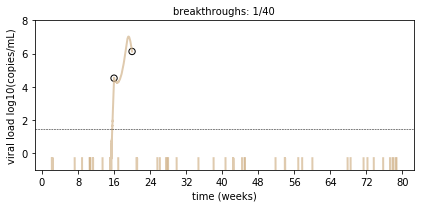

In [85]:
#now simple test of trial including VRC01
%time tr=AMPmodule.trial(name='test', nps=40, tF=560, dose=30, clade='C', rfrac=0, A0=1, iv_phi=1, maxIC50=50, v_flg=True, keep_flg=2)

#plot trial outcome
plt.figure(figsize=(6,3))
for ip in range(tr.nps):
    plt.scatter(tr.obz[0][ip][tr.obz[1][ip]>30]/7,
                np.log10(tr.obz[1][ip][tr.obz[1][ip]>30]),
                facecolors='none',edgecolors='k',s=40)#,c=plt.cm.jet(ip))#1.4**ip),alpha=0.7)
    #plt.scatter(tr.obz[0][ip]/7,np.log10(tr.obz[1][ip]+4e-4*1.1**ip),facecolors='none',edgecolors='k',s=40)#,c=plt.cm.jet(ip))#1.4**ip),alpha=0.7)
    plt.plot(tr.sim[0][ip][tr.sim[1][ip]>-3]/7,
             tr.sim[1][ip][tr.sim[1][ip]>-3],
             lw=2,color='tan',alpha=0.7)
    
plt.axhline(np.log10(30),color='k',ls='--',lw=0.5)
plt.xticks(range(0,82,8))#,fontsize=8)
plt.ylim([-1,8])
plt.ylabel('viral load log10(copies/mL)')
plt.xlabel('time (weeks)')
plt.title('breakthroughs: '+str(sum(tr.brks>0))+'/'+str(tr.nps),fontsize=10)
plt.tight_layout()
plt.savefig('figures/trial_30test.pdf',dpi=600)

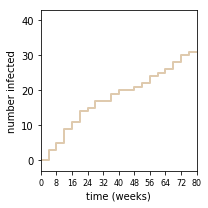

In [88]:
#calculate incidence
inc=np.zeros(len(tr.obz[0][0]))
for i in range(len(tr.obz[0][0])):
    inc[i]=np.sum(tr.brks[tr.brks>0]<tr.obz[0][0][i]) 
    
plt.figure(figsize=(3,3))
plt.step(tr.obz[0][0]/7,inc,lw=2,color='tan',alpha=0.7)
plt.ylabel('number infected')
plt.xlim([0,80])
plt.ylim([-3,43])

plt.xticks(range(0,82,8),fontsize=8)
plt.xlabel('time (weeks)')
plt.tight_layout()
#plt.savefig('figures/trial_30test-inc.pdf',dpi=600)

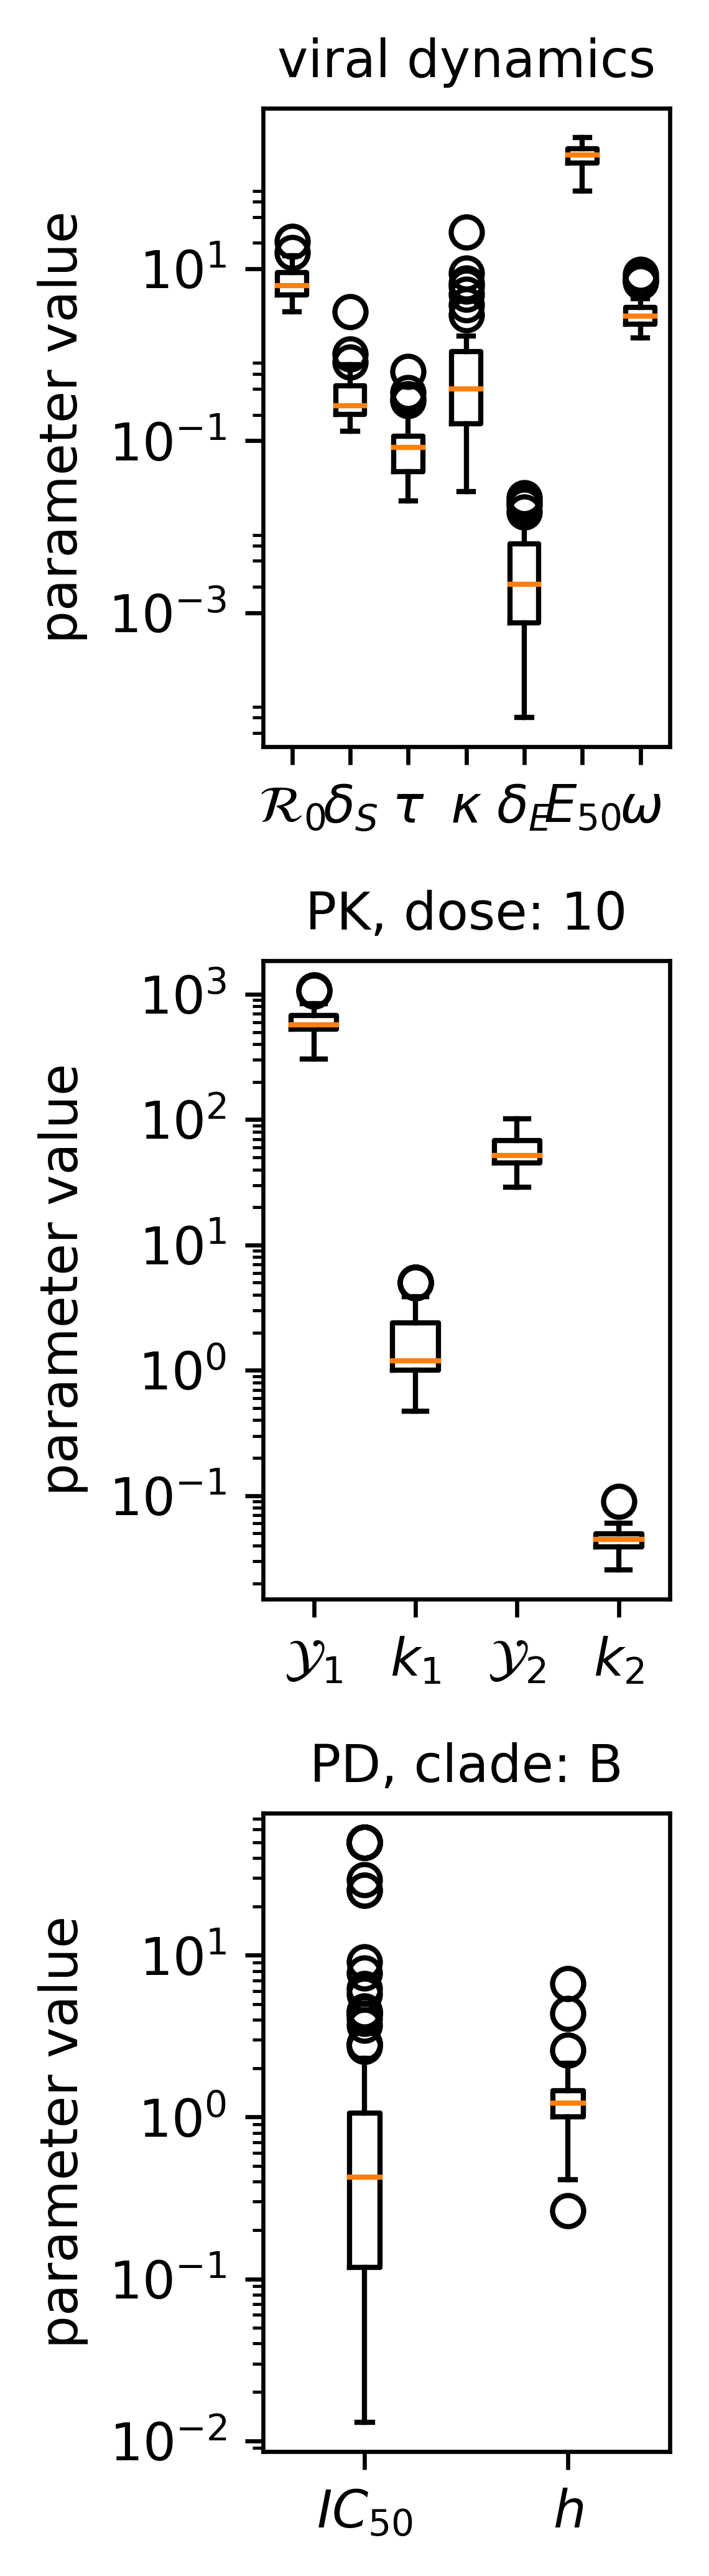

In [33]:
#### just to check on parameters
plt.figure(figsize=(2,7),dpi=rez)

plt.subplot(311)
plt.boxplot(tr.VD)
plt.semilogy()
plt.xticks(np.arange(7)+1,
           [r'$\mathcal{R}_0$',r'$\delta_S$',r'$\tau$',r'$\kappa$',r'$\delta_E$',r'$E_{50}$',r'$\omega$'])
plt.ylabel('parameter value')
plt.title('viral dynamics',fontsize=10)

plt.subplot(312)
plt.boxplot(tr.PK)
plt.semilogy()
plt.xticks(np.arange(4)+1,[r'$\mathcal{Y}_1$',r'$k_1$',r'$\mathcal{Y}_2$',r'$k_2$'])
plt.title('PK, dose: ' + str(tr.dose),fontsize=10)
plt.ylabel('parameter value')

plt.subplot(313)
plt.boxplot(tr.PD)
plt.semilogy()
plt.xticks(np.arange(2)+1,[r'$IC_{50}$',r'$h$'])
plt.title('PD, clade: ' + str(tr.clade),fontsize=10)
plt.ylabel('parameter value')

plt.tight_layout()
plt.savefig('figures/trial_params.pdf')

In [10]:
#compare trials with sort of kaplan meier thingy

#first, control trial

N=100 #number of participants in each trial

%time tr_ctl=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=0, clade='all', rfrac=0, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)
%time tr_10B=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=10, clade='B', rfrac=0, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)
%time tr_10C=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=10, clade='C', rfrac=0, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)
%time tr_30B=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=30, clade='B', rfrac=0, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)
%time tr_30C=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=30, clade='C', rfrac=0, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)



CPU times: user 46 s, sys: 53.8 ms, total: 46 s
Wall time: 46.2 s
CPU times: user 7.33 s, sys: 4.67 ms, total: 7.34 s
Wall time: 7.34 s
CPU times: user 8.79 s, sys: 7.83 ms, total: 8.79 s
Wall time: 8.86 s
CPU times: user 6 s, sys: 5.64 ms, total: 6.01 s
Wall time: 6.02 s
CPU times: user 4.91 s, sys: 4.11 ms, total: 4.91 s
Wall time: 4.92 s


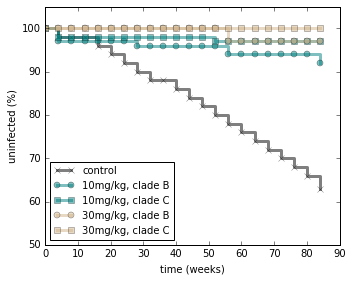

In [11]:
trl=[tr_ctl,tr_10B,tr_10C,tr_30B,tr_30C]
colz=['k','teal','teal','tan','tan']
lz=['-',':','-',':','-']
mz=['x','o','s','o','s']
trz=['control','10mg/kg, clade B','10mg/kg, clade C','30mg/kg, clade B','30mg/kg, clade C']
plt.figure(figsize=(5,4),dpi=rez)
for i in range(len(trl)):
    tr=trl[i]
    obs_t=tr.obz[0][0]
    pct_u=np.zeros([len(obs_t)])
    u=N
    for tt in range(len(obs_t)):
        pct_u[tt]=u/N*100
        u=u-np.sum(tr.obz[1][tt]>0)
    
    plt.step(obs_t/7,pct_u,where='post',lw=3,color=colz[i],marker=mz[i],alpha=0.5)
    #plt.step(obs_t/7,pct_u,where='post',lw=3,color=plt.cm.cool(i/len(trl)),ls=lz[i],alpha=0.5)
plt.ylabel('uninfected (%)')
plt.xlabel('time (weeks)')
plt.legend(trz,fontsize=10,loc=3)
plt.ylim([50,105])
plt.tight_layout()
plt.savefig('figures/kaplanM.pdf')

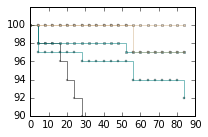

In [12]:
#zoomed in plot
plt.figure(figsize=(3,2),dpi=rez)
for i in range(len(trl)):
    tr=trl[i]
    obs_t=tr.obz[0][0]
    pct_u=np.zeros([len(obs_t)])
    u=N
    for tt in range(len(obs_t)):
        pct_u[tt]=u/N*100
        u=u-np.sum(tr.obz[1][tt]>0)
    
    plt.step(obs_t/7,pct_u,where='post',lw=1,color=colz[i],marker=mz[i],markersize=2,alpha=0.5)
    #plt.step(obs_t/7,pct_u,where='post',lw=3,color=plt.cm.cool(i/len(trl)),ls=lz[i],alpha=0.5)
#plt.ylabel('uninfected (%)')
#plt.xlabel('time (weeks)')
#plt.legend(trz,fontsize=10,loc=3)
plt.ylim([90,102])
plt.yticks(range(90,102,2))
plt.tight_layout()
plt.savefig('figures/kaplanMzoom.pdf')

In [ ]:
#compare trials with sort of kaplan meier thingy
#sensitivity analysis!

#first, control trial

N=100 #number of participants in each trial

%time Str_ctl=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=0, clade='all', A0=1, iv_phi=10, maxIC50=50, v_flg=False, keep_flg=2)
%time Str_10B=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=10, clade='B', A0=1, iv_phi=10, maxIC50=50, v_flg=False, keep_flg=2)
%time Str_10C=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=10, clade='C', A0=1, iv_phi=10, maxIC50=50, v_flg=False, keep_flg=2)
%time Str_30B=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=30, clade='B', A0=1, iv_phi=10, maxIC50=50, v_flg=False, keep_flg=2)
%time Str_30C=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=30, clade='C', A0=1, iv_phi=10, maxIC50=50, v_flg=False, keep_flg=2)



In [ ]:
Strl=[Str_ctl,Str_10B,Str_10C,Str_30B,Str_30C]
colz=['k','teal','teal','tan','tan']
lz=['-',':','-',':','-']
mz=['x','o','s','o','s']
trz=['control','10mg/kg, clade B','10mg/kg, clade C','30mg/kg, clade B','30mg/kg, clade C']
plt.figure(figsize=(5,4),dpi=rez)
for i in range(len(Strl)):
    tr=Strl[i]
    obs_t=tr.obz[0][0]
    pct_u=np.zeros([len(obs_t)])
    u=N
    for tt in range(len(obs_t)):
        pct_u[tt]=u/N*100
        u=u-np.sum(tr.obz[1][tt]>0)
    
    plt.step(obs_t/7,pct_u,where='post',lw=3,color=colz[i],marker=mz[i],alpha=0.5)
    #plt.step(obs_t/7,pct_u,where='post',lw=3,color=plt.cm.cool(i/len(trl)),ls=lz[i],alpha=0.5)
plt.ylabel('uninfected (%)')
plt.xlabel('time (weeks)')
plt.legend(trz,fontsize=10,loc=3)
plt.ylim([80,102])
plt.yticks(range(80,102,2))

plt.tight_layout()
plt.savefig('figures/kaplanMS10.pdf')

exposure week: [ 46.  71.   5.  62.  71.   8.  49.  77.  24.   9.]
exposure interval (1st or 2nd): [ 2.  2.  2.  2.  2.  1.  1.  2.  1.  1.]


In [18]:
len(tr.bt_ic50s)

100

In [67]:
#gather all the trial outputs we want

#first positive viral loads
%time tr_ctl=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=0, clade='all', rfrac=0, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)

tr=tr_ctl

def gather_output(tr):
    #detection times and intervals
    fpts=tr.fp_ts[tr.fp_vs>0]
    fpis=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2

    #first positive viral loads of breakthru infections
    fpvls=tr.fp_vs[tr.fp_vs>0] 
    fpvls1=fpvls[fpis==1]
    fpvls2=fpvls[fpis==2]

    IC50s=tr.bt_ic50s[tr.fp_vs>0]
    IC50s1=IC50s[fpis==1]
    IC50s2=IC50s[fpis==2]
    
    return fpts,fpis,fpvls,fpvls1,fpvls2,IC50s,IC50s1,IC50s2


KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x11e2147f0>,
 <a list of 3 Text xticklabel objects>)

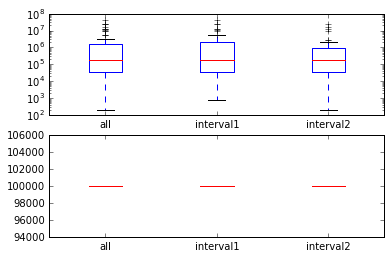

In [52]:
plt.subplot(211)
plt.boxplot([fpvls,fpvls1,fpvls2])
plt.semilogy()
plt.xticks([1,2,3],['all','interval1','interval2'])

plt.subplot(212)
plt.boxplot([IC50s,IC50s1,IC50s2])
#plt.semilogy()
plt.xticks([1,2,3],['all','interval1','interval2'])


In [26]:
#have to figure out if detected interval represents real exposure interval

#check the calculation
print('exposure week:',np.floor(tr_ctl.ex_ts[:10]/7))
print('exposure interval (1st or 2nd):',1+np.floor(tr_ctl.ex_ts[:10]/7/4)%2)

#make the matrix of exposures > detections
def calc_brksmat(tr):
    exts=1+np.floor(tr.ex_ts[tr.fp_ts>0]/7/4)%2
    fpts=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2
    brksmat=np.zeros([2,2])
    for i in range(len(exts)):    
        if exts[i]==1 and fpts[i]==1:
            brksmat[0,0]+=1 #exp 1, det 1
        if exts[i]==1 and fpts[i]==2:
            brksmat[0,1]+=1 #exp 1, det 2
        if exts[i]==2 and fpts[i]==1:
            brksmat[1,0]+=1 #exp 2, det next 1
        if exts[i]==2 and fpts[i]==2:
            brksmat[1,1]+=1 #exp 2, det 2

    return brksmat

exposure week: [ 46.  71.   5.  62.  71.   8.  49.  77.  24.   9.]
exposure interval (1st or 2nd): [ 2.  2.  2.  2.  2.  1.  1.  2.  1.  1.]


In [66]:
#print some stuff so we can see how to read this thing
brksmat=calc_brksmat(tr)
print(brksmat,'\n')
print('exp 1, det 1:',brksmat[0,0])
print('exp 1, det 2:',brksmat[0,1])
print('exp 2, det 1:',brksmat[1,0])
print('exp 2, det 2:',brksmat[1,1],'\n')

print('true brks:',np.sum(brksmat,1))
print('obs brks:',np.sum(brksmat,0),'\n')

print('tot clrs:',np.sum(tr.clrs>0))
print('tot occl:',tr.nps-np.sum(tr.clrs>0)-sum(np.sum(brksmat,1)),'\n')

print('fraction delayed in 1 =',brksmat[1,0]/(brksmat[0,0]+brksmat[1,0]))
print('fraction delayed in 2 =',brksmat[0,1]/(brksmat[0,1]+brksmat[1,1]),'\n')


[[ 14.  34.]
 [ 32.   8.]] 

exp 1, det 1: 14.0
exp 1, det 2: 34.0
exp 2, det 1: 32.0
exp 2, det 2: 8.0 

true brks: [ 48.  40.]
obs brks: [ 46.  42.] 

tot clrs: 10
tot occl: 2.0 

fraction delayed in 1 = 0.695652173913
fraction delayed in 2 = 0.809523809524 



In [34]:
plt.figure(figsize=(4,3))
tr=tr_ctl
plt.plot(np.random.normal(1,0.1,sum(tr.fp_ts>0))+np.floor(tr.ex_ts[tr.fp_ts>0]/7/4)%2,
         np.random.normal(1,0.1,sum(tr.fp_ts>0))+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2,marker='s',alpha=0.3,lw=0)

plt.xlabel('exposure interval')
plt.ylabel('first positive interval')
plt.xticks([1,2],['1st (high)','2nd (low)'])
plt.yticks([1,2],['1st (high)','2nd (low)'])

plt.xlim([0.5,2.5])
plt.ylim([0.5,2.5])
for i in range(2):
    for j in range(2):
        plt.annotate(str(int(brksmat[i,j])),[i+1.3,j+1])
plt.tight_layout()
plt.savefig('figures/runover_tr.pdf')


NameError: name 'tr_ctl' is not defined

In [ ]:
#show the same delay effect happens for global sensitivity analysis?

plt.figure(figsize=(5,3),dpi=rez)

plt.plot(phis,obsbrks1/truebrks1)
plt.plot(phis,obsbrks2/truebrks2)
plt.ylabel('ratio observed to true')
plt.xlabel('in vivo IC50 multiplier, $\phi$')
plt.semilogx()

plt.legend(['interval 1','interval 2'],fontsize=10,loc=4)
plt.tight_layout()
plt.savefig('figures/phi_intervalbrks-ratio.pdf')
    
#plt.xlabel('exposure interval')
#plt.ylabel('first positive interval')
#plt.xticks([0,1],['2nd-low','1st-high'])
#plt.yticks([0,1],['2nd-low','1st-high'])

plt.tight_layout()